In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [43]:
#define our quantum and classical registers as well as our nondeferred quantum circuit
#Without deferred measurement ---> retaining mid-circuit projective measurements

qr0 = QuantumRegister(1, name="q_{psi}") #defines our quantum register containing Alice's messenger
qr1 = QuantumRegister(1, name="q_{a}") #defines our quantum register containing Alice's entangled qubit
qr2 = QuantumRegister(1, name="q_{b}") #defines our quantum register containing Bob's entangled qubit
cr0 = ClassicalRegister(1, name="c_psi") #defines our first classical register containing a single bit
cr1 = ClassicalRegister(2, name="c_a") #defines our second classical register containing another single bit as well
original_qc = QuantumCircuit(qr0, qr1, qr2, cr0, cr1) 
#defines our nondeferred teleportation circuit using registers qr0,qr1,qr2, cr0, cr1

In [44]:
#define our key functions in the protocol 

def generate_bell_pair(qc, a, b):
    qc.h(a) 
    qc.cx(a, b)
#generates Bell state pair B_{00} using qubits a and b on quantum circuit qc
#first applies hadamard gate to qubit shifting its state to superpostiion state
#then applies CNOT gate using qubit a as control and qubit b as target 

def A_gates(qc, Messenger, a):
    qc.barrier()
    qc.cx(Messenger,a)
    qc.h(Messenger)
#define a function describing how Alice's first action to her qubits (messenger and a) on quantum circuit qc
#first performs CNOT gate on target a with control messenger then applies hadamard to messenger 

def A_measure_send(qc, messenger, a):
    qc.barrier()    
    qc.measure(messenger, 0)
    qc.measure(a, 1)
#defines Alice's mid circuit measurement step for her qubits (original protocol only)
#Applies projective measurement mapping result from qubit mesenger to first classical register
#and qubit a result to second register

def B_gates(qc, qubit, crz, crx):
    qc.barrier()
    qc.x(qubit).c_if(crx, 1) 
    qc.z(qubit).c_if(crz, 1)
#defines Bob's action on his qubit in response to receiving classsical bit information of Alice's qubits
#applies z-gate to his qubit if and only if first classical register reads out 1
#applies x-gate to his qubit if and only if second classical register reads out 1

psi = random_state(1)
init_gate = Initialize(psi)
init_gate.label = "init"
#Initalize Alice's messenger qubit labelled psi, random_state takes a qubit amount of 1 and randomizes it's coefficients
#then applying "Initialize" to psi which merely resets our state 
#note this is not a quanutm gate since the action is not unitary/reversible nonetheless we label it as init

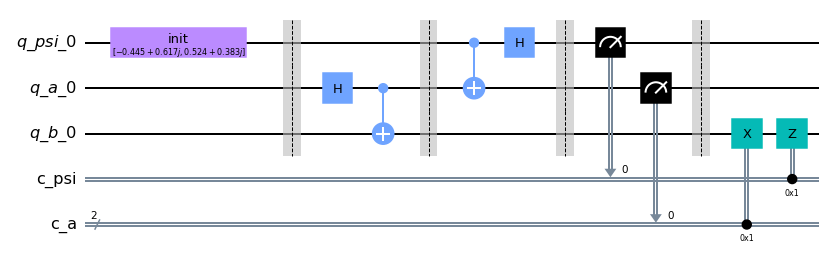

In [45]:
#Original Protocol

original_qc.append(init_gate, [0])
original_qc.barrier()
#randomize messenger qubit

generate_bell_pair(original_qc, 1, 2)
#bell state generated between Alice's 2nd qubit and Bob's qubit

A_gates(original_qc, 0, 1)
#Alice applies CNOT then Hadamard on messenger qubit operation

A_measure_send(original_qc, 0, 1)
#Alice measures and sends her qubit states to Bob

B_gates(original_qc, 2, cr0, cr1)
#Bob applies necessary corrections to his qubit to transform it to state psi

original_qc.draw()

<IPython.core.display.Latex object>

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:68: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


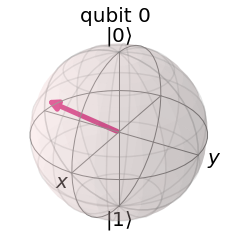

In [46]:
#We can then check our that our teleportation worked by simulating our states 
#first simulate our initialized state for psi with labelling our 

display(array_to_latex(psi, prefix = " |\\psi\\rangle ="))
plot_bloch_multivector(psi)               

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:68: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


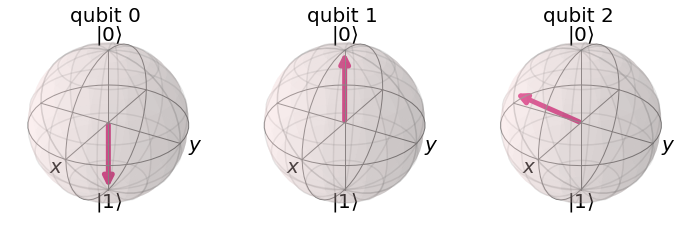

In [47]:
sim = Aer.get_backend('aer_simulator')
original_qc.save_statevector()
out_vector = sim.run(original_qc).result().get_statevector()
plot_bloch_multivector(out_vector)

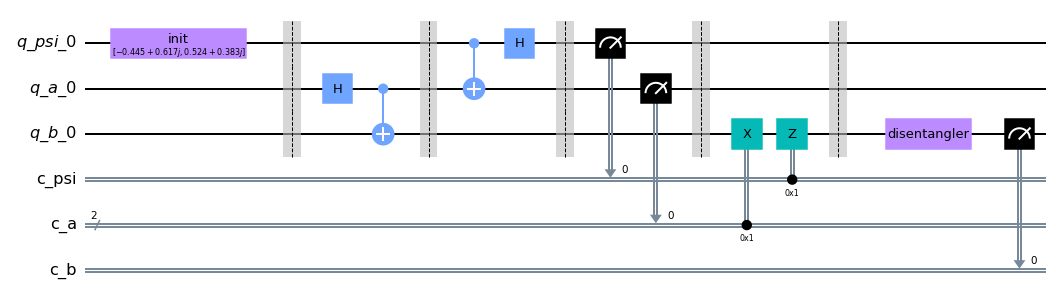

In [48]:
#Realistic/Experimental model

#here we notice that the bloch sphere plots for bob's qubit and Alice's messenger match 
#confirming we've teleported the state!

#However because on a real quantum computer we're not actually able to sample back this initialized state teleported to 
#Bob's qubit, we must apply the gates used to initialize psi in reverse to bob's qubit and then compare if the states match. 

#We then define our inverse initialize gate and add it to our circuit applying to bob's qubit:
inverse_init_gate = init_gate.gates_to_uncompute()
original_qc.append(inverse_init_gate, [2])

#in order to finish our check in a realistic model, we also measure bob's qubit 
#and store it in an additional classical register 
c2 = ClassicalRegister(1, name = 'c_b')
original_qc.add_register(c2)

original_qc.measure(2,3)
original_qc.draw()

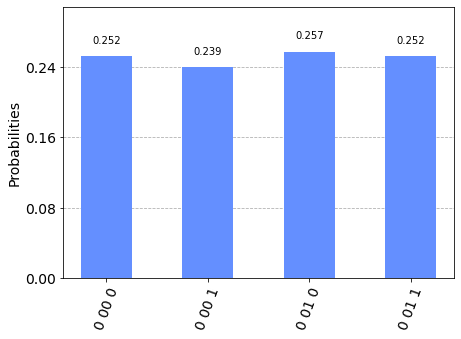

In [50]:
#next we can analyze our results in the form of classical bits since we collapsed the quantum states for each qubit 
#compile it on a histogram and in using the "aer simulator" to simulate an ensemble of experiments
#we would expect our results for each of the four possible states of Alice's qubits to normalize to 1 
#and still measure bob's qubit in the same state 

t_qc = transpile(original_qc, sim)
counts = sim.run(t_qc).result().get_counts()
plot_histogram(counts)


In [51]:
#the most 3rd most siginificant bit is what bob measured his qubit state to be
# the first two bits are Alice's a and messenger bits respectively
# we see here that for all four possible outcomes for Alice's measurements 
# 00, 01, 10, 11 ; Bob always measures his qubit to be 0 with a hundred percent probability

In [53]:
#Deferred measurement and modified circuit

#due to IBM's hardware limitations preventing us from further gate operations after a projective measurement 
#we must exploit the deferred measurement principle which
#allows us to postpone any mid-circuit projective measurements to the end of our scheme 
#without altering the function of our protocol

#and so we define a new quantum circuit deferred_circuit which is identical to original_circuit except for 
#a new function describing Bob's action in the procedure

def B_new_gates(qc, a, b, c):
    qc.barrier()
    qc.cx(a,c)
    qc.cz(b,c)
#instead we assume Bob has a quantum communication channel with both of Alice's qubits where he 
#applies a controlled x-gate applied to his qubit if and only if the messenger-state received in the 1 state
#then applies a controlled z-gate applied to his qubit if and only if the a-state received is in the 1 state

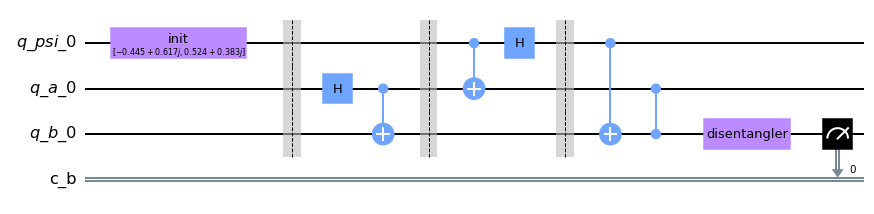

In [56]:
#Deferred protocol
deferred_qc = QuantumCircuit(qr0, qr1, qr2, c2)

deferred_qc.append(init_gate, [0])
deferred_qc.barrier()
#randomize Alice's messenger qubit

generate_bell_pair(deferred_qc, 1, 2)
#bell state generated between Alice's 2nd qubit and Bob's qubit

A_gates(deferred_qc, 0, 1)
deferred_qc.barrier()
#Alice applies CNOT then Hadamard on messenger qubit operation

B_new_gates(deferred_qc, 0, 1, 2)
#Bob applies necessary corrections using controlled quantum x and z gates instead 
#to his qubit to transform it to state psi

deferred_qc.append(inverse_init_gate, [2])
#bob applies gates used to randomize psi but in reverse in order to properly sample his state

deferred_qc.measure(2,0)

deferred_qc.draw()

In [57]:
#IBMQ measurements
#then we run this circuit through IBM's computer and receive our lab data 

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
#sees which devices are available using one of IBM's accounts

ibmqfactory.load_account:WARNING:2021-08-14 05:13:56,104: Credentials are already in use. The existing account in the session will be replaced.


In [58]:
# gets the least-busy backend at IBM and runs the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_deferred_qc = transpile(deferred_qc, backend, optimization_level=3)
job = backend.run(t_deferred_qc)
job_monitor(job)  # displays job status under cell

Job Status: job has successfully run


{'0': 874, '1': 150}


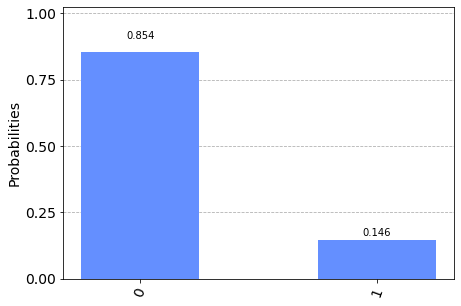

In [64]:
# Displays Bob's results as a histogram for detecting 0 or 1
exp_result = job.result()
exp_counts = exp_result.get_counts(deferred_qc)
print(exp_counts)
plot_histogram(exp_counts)

In [63]:
print(f"The experimental error rate : {exp_counts['1']*100/sum(exp_counts.values()):.3f}%")

The experimental error rate : 14.648%
